# Notebook - short
functions in one place to use it efficiently

In [2]:
# required libraries
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math
import scipy
import itertools

In [23]:
#
# Fundamental values of the grid
#
def t_calc(
        a,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    return 1 / (2 * m_eff * a ** 2) * (hbar ** 2) / (m_0 * 10e-20 * _1eV)   # [eV]

def a_calc(
        site_size,
        site_elements
):
    return site_size / (site_elements - 1) # [Angstrom] - distance between elements 

#
# Dispersion 2D
#
def dispersion_2D(
    site_elements,
    t,
    a,
    hbar,
    m_eff, 
    m_0,
    _1eV,
    E0,
    dEs):
    pi = np.pi
    kx = np.linspace(-pi/a,pi/a,site_elements)
    ky = np.linspace(-pi/a,pi/a,site_elements)
    kxx, kyy = np.meshgrid(kx, ky)
    dEs = 0

    # kp
    f = lambda kx, ky: (hbar ** 2) * (kx ** 2 + ky ** 2) / (2 * m_eff * m_0 * _1eV * 10e-20) + E0
    ek_kp = np.array(list(map(f, kxx, kyy)))


    # cos
    ek_cos = dEs - 2 * t * (np.cos(kxx * a) + np.cos(kyy * a))

    # scale the ek_cos so it will start at 0
    f = lambda x: x - delta
    delta = np.amin(ek_cos)
    ek_cos = np.array(list(map(f, ek_cos)))

    # plot dispersion
    plt.plot(kx,ek_cos[0],'o', mfc = 'none', mec = 'blue', color="blue", label="cos()")
    for i in range(1,site_elements):
        plt.plot(kx,ek_cos[i],'o', mfc = 'none', mec = 'blue', color="blue")
    plt.plot(kx,ek_kp[0],'.', color="red", label="kp")
    for i in range(1,site_elements):    
        plt.plot(kx,ek_kp[i],'.', color="red")
    plt.xlabel("k (1/A)")
    plt.ylabel("E (eV)")
    plt.hlines(8*t, -pi/a, pi/a, colors="black", linestyles="--")
    plt.hlines(0, -pi/a, pi/a, colors="black", linestyles="--")
    plt.vlines(-pi/a, 0, np.amax(ek_kp), colors="black", linestyles="--")
    plt.vlines(pi/a, 0, np.amax(ek_kp), colors="black", linestyles="--")
    plt.legend()
    plt.show()


#
# Layout
#
def initialize_layout(site_elements, a):
    Layout = {"2Dneighbours": np.zeros((site_elements, site_elements), dtype=int),
              "realLocation": [[[]]]}
    k = 1
    for i in range(site_elements):
        for j in range(site_elements):
            Layout["2Dneighbours"][j][i] = k
            Layout["realLocation"].append([k,[a*i,a*j]])
            k += 1
    Layout["realLocation"] = Layout["realLocation"][1:]

    return Layout

def plot_layout(Layout):
    X = np.zeros(len(Layout["realLocation"]))
    Y = np.zeros(len(Layout["realLocation"]))
    for i in range(len(Layout["realLocation"])):
        elem = Layout["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]
    plt.scatter(X, Y, c='blue', linewidths=1)

    plt.gca().set_aspect('equal', 'box')
    plt.show()   



#
# Hamiltonian
#
def initialize_hamiltonian(Layout, t, PBC:bool, V_max, r_0):
    site_elements = Layout["2Dneighbours"].shape[0]
    elements = site_elements**2
    Hamiltonian = np.zeros((elements,elements))
    
    for i in range(site_elements):
        for j in range(site_elements):
            elem = Layout["2Dneighbours"][i,j] - 1

            next_x, prev_x, next_y, prev_y = neighbours(Layout["2Dneighbours"], i, j, PBC)

            if next_x in range(elements):
                Hamiltonian[next_x,elem] = -t
                Hamiltonian[elem,next_x] = -t

            if prev_x in range(elements):    
                Hamiltonian[prev_x,elem] = -t
                Hamiltonian[elem,prev_x] = -t

            if next_y in range(elements):
                Hamiltonian[next_y,elem] = -t
                Hamiltonian[elem,next_y] = -t
            
            if prev_y in range(elements):
                Hamiltonian[prev_y,elem] = -t
                Hamiltonian[elem,prev_y] = -t

    for i in range(elements):

       Hamiltonian[i][i] = 4*t + V(i+1, Layout, V_max, r_0)
       
    return Hamiltonian

def neighbours(Layout, i, j, PBC:bool):
    site_elements = Layout.shape[0]
    if PBC:
        #print("PBC True")
        if j in range(1,site_elements-1):
            next_y = j + 1
            prev_y = j - 1
        elif j == 0:
            next_y = j + 1
            prev_y = site_elements-1
        else:
            next_y = 0
            prev_y = j - 1

        if i in range(1,site_elements-1):
            next_x = i + 1
            prev_x = i - 1
        elif i == 0:
            next_x = i + 1
            prev_x = site_elements-1
        else:
            next_x = 0
            prev_x = i - 1
        
        return Layout[next_x,j]-1, Layout[prev_x,j]-1, Layout[i,next_y]-1, Layout[i,prev_y]-1 
    else:
        next_y = j + 1
        prev_y = j - 1
        next_x = i + 1
        prev_x = i - 1

        if prev_y in range(0,site_elements):
            prev_y_elem = Layout[i,prev_y]-1 
        else:
            prev_y_elem = -1
        if next_y in range(0,site_elements):
            next_y_elem = Layout[i,next_y]-1
        else:
            next_y_elem = -1
        if prev_x in range(0,site_elements):
            prev_x_elem =  Layout[prev_x,j]-1
        else:
            prev_x_elem = -1
        if next_x in range(0,site_elements):
            next_x_elem =  Layout[next_x,j]-1
        else:
            next_x_elem = -1

        return next_x_elem, prev_x_elem, next_y_elem, prev_y_elem 

def diagonalize_hamiltonian(Hamiltonian):
    E,psiT = np.linalg.eigh(Hamiltonian) # This computes the eigen values and eigenvectors
    #psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
    #plt.plot(E, 'o')
    #plt.show()
    return E

def diagonalize_hamiltonian_with_psi(Hamiltonian):
    E,psiT = np.linalg.eigh(Hamiltonian) # This computes the eigen values and eigenvectors
    psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
    #plt.plot(E, 'o')
    #plt.show()
    return E, psi

def show_hamiltonian(Hamiltonian):
    Hamiltonian = np.flip(Hamiltonian,axis=1)
    ran = math.floor(math.sqrt(Hamiltonian.size))
    fig, ax = plt.subplots()
    pcm = ax.imshow(Hamiltonian, cmap='hot', extent=[0, ran, 0, ran])
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.invert_yaxis()
    ax.xaxis.set_label_position('top')
    fig.colorbar(pcm, ax=ax)
    plt.show()

def plot_eigenvalues_hamiltonian_whole(diagonalizated_hamiltonain, t):
    plt.plot(diagonalizated_hamiltonain, '.')
    # bottom = np.amin(diagonalizated_hamiltonain)
    plt.hlines(8*t, 0, len(diagonalizated_hamiltonain), colors="red", linestyles="--")
    plt.hlines(0, 0, len(diagonalizated_hamiltonain), colors="red", linestyles="--")
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.show()

def plot_eigenvalues_hamiltonian(diagonalizated_hamiltonain):
    plt.plot(diagonalizated_hamiltonain, 'o')
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.show()

def plot_multiple_eigenvalues_hamiltonian(diagonalizated_hamiltonain_list, label_list, plot_first):
    i=0
    for diagH in diagonalizated_hamiltonain_list:
        plt.plot(diagH[:plot_first], 'o', label=label_list[i])
        i+=1
    plt.xlabel("eigenvalue index")
    plt.ylabel("E (eV)")
    plt.legend()
    plt.show()

def eigenvalues_hamiltonian(
        site_size,
        site_elements,
        PBC:bool,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    a = a_calc(site_size=site_size, site_elements=site_elements)
    t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    Layout = initialize_layout(site_elements, a)
    Hamiltonian = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
    return diagonalize_hamiltonian(Hamiltonian)


#
# Potential
#
def V(i, Layout, V_max, r_0):
    dist_sqr = distance_sqr_from_center(i, Layout)
    return V_n_direct(dist_sqr, V_max, r_0)

def V_n_direct(dist_sqr, V_max, r_0):
    dist_sqr = abs(dist_sqr)
    if np.sqrt(dist_sqr) >= r_0:
        return 0
    else:
        return V_max/(r_0*r_0) * dist_sqr - V_max

def distance_sqr_from_center(elem1, Layout):
    site_size = Layout["realLocation"][len(Layout["realLocation"])-1][1][0]
    center = site_size/2
    #for p_elem in Layout["realLocation"]:
    #    if elem1 == p_elem[0]:
    #        x1, y1 = p_elem[1][0], p_elem[1][1]
    x1, y1 = Layout["realLocation"][elem1-1][1][0], Layout["realLocation"][elem1-1][1][1]
    return (x1 - center)**2 + (y1 - center)**2

def plot_potential_on_grid(Layout_base, site_size, site_elements, V_max, r_0):
    a = a_calc(site_size, site_elements)
    Layout = initialize_layout(site_elements, a)

    Potencial = np.zeros_like(Layout["2Dneighbours"], dtype=float)
    for i in range(site_elements):
        for j in range(site_elements):
            Potencial[j,i] = V((i*site_elements+j+1), Layout, V_max, r_0)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]

    plt.scatter(X, Y, c='blue', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.imshow(Potencial, cmap=cm.plasma, extent = [0, site_size, 0, site_size])
    plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.show()

def plot_potential_on_grid_heat(Layout_base, site_size, site_elements, V_max, r_0):
    a = a_calc(site_size, site_elements)
    Layout = initialize_layout(site_elements, a)

    Potencial = np.zeros_like(Layout["2Dneighbours"], dtype=float)
    for i in range(site_elements):
        for j in range(site_elements):
            Potencial[j,i] = V((i*site_elements+j+1), Layout, V_max, r_0)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]

    plt.scatter(X, Y, c='blue', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    #plt.imshow(Potencial, cmap=cm.plasma, extent = [0, site_size, 0, site_size])
    #plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.show()

def plot_psi_on_grid(psi, i, Layout_base, site_size, site_elements, r_0):
    center = site_size/2
    psi_test = np.reshape(psi[i], (-1, site_elements))
    circle = plt.Circle((center, center), r_0, color='black', fill=False)

    X = np.zeros(len(Layout_base["realLocation"]))
    Y = np.zeros(len(Layout_base["realLocation"]))
    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]

    plt.scatter(X, Y, c=psi_test.flatten(), linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.gca().add_patch(circle)
    plt.colorbar()
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.show()

#
# Analitical energies
#
def omega_calc(V, r, m_eff, m_0, _1eV): # in [J]
    return np.sqrt((2*V*_1eV)/(m_eff*m_0*(r*10e-10)**2)) #* 3.0857824231583795

def analitical_state(n_1, n_2, omega, V, hbar, _1eV):
    hbar = np.pi * hbar / _1eV
    return hbar * omega  * (n_1 + n_2 + 1) - V

def analitical_energies(N, omega, V, hbar, _1eV):
    n_x = N #math.floor(math.sqrt(N))
    #fill_more = N - n_x**2
    n = np.arange(0, n_x, 1)
    
    x = list(itertools.product(n, n))
    Energies = np.zeros(len(x))
    i = 0
    for elem in x:
        Energies[i] = analitical_state(elem[0], elem[1], omega, V, hbar, _1eV)
        i+=1
    return np.sort(Energies)

#
# Wave function psi
#
def plot_psi(psi):
    j = 0
    for i in psi:
        plt.plot(i, '.', label=j)
        j+=1
    plt.xlabel("x [A]")
    plt.ylabel("psi")
    plt.legend()
    plt.show()

def plot_psi_range(psi, i=0, j=5):
    for k in range(i, j):
        plt.plot(psi[:, k], '.', label=k)
    plt.xlabel("x [A]")
    plt.ylabel("psi")
    plt.legend()
    plt.show()

def plot_psi_n(psi, n):
    x = np.linspace(np.amin(psi[:, n]), np.amax(psi[:, n]), len(psi[:, n]))
    plt.plot(x, psi[:, n], '.', label=n)
    plt.xlabel("x [A]")
    plt.ylabel("psi")
    plt.legend()
    plt.show()

def psi_in_dot(psi, i, Layout_base, site_elements, r_0):
    psi_test = np.reshape(psi[i], (-1, site_elements)).flatten()

    psi_inside = 0
    psi_outside = 0

    for i in range(len(Layout_base["realLocation"])):
        elem = Layout_base["realLocation"][i]
        dist_sqr = distance_sqr_from_center(elem[0], Layout_base)
        if np.sqrt(dist_sqr) < r_0:
            psi_inside += abs(psi_test[i])
        else:
            psi_outside += abs(psi_test[i])

    return 100*psi_inside/(psi_inside+psi_outside)

def p_psi_on_n(psi, n, Layout_base, site_elements, r_0):
    Y = np.zeros(n)
    for i in range(n):
        Y[i] = psi_in_dot(psi, i, Layout_base, site_elements, r_0)
    plt.plot(Y)
    plt.show()

def psi_in_dot_1D(psi, i, site_size, site_elements, r_0):
    center = site_size/2
    x = np.linspace(0, site_size, site_elements)
    psi_test = np.reshape(psi[i], (-1, site_elements))[int(site_elements/2)]
    plt.plot(x, psi_test)
    plt.xlabel("x [A]")
    plt.ylabel("y [A]")
    plt.vlines(center-r_0, np.amin(psi_test), np.amax(psi_test), colors="black", linestyles="--")
    plt.vlines(center+r_0, np.amin(psi_test), np.amax(psi_test), colors="black", linestyles="--")
    plt.show()

In [113]:
# definitions of fundamental constant used in calculations
site_size = 500
site_elements = 100
PBC = False
V_max = 0.3 
r_0 = 100
m_eff = 0.067
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar = scipy.constants.hbar
_1eV = scipy.constants.physical_constants["electron volt"][0]
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)

In [114]:
omega = omega_calc(V_max, r_0, m_eff, m_0,  _1eV)
print(omega, hbar * omega,  hbar * omega / _1eV, m_eff, m_0)


Layout = initialize_layout(site_elements, a)
#plot_layout(Layout)
H = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
#show_hamiltonian(H)
#diagH = diagonalize_hamiltonian(H)
diagH, psi = diagonalize_hamiltonian_with_psi(H)
#plot_potential_on_grid(Layout, site_size, site_elements, V_max, r_0)
#plot_potential_on_grid(Layout, site_size, 100, V_max, r_0)
#show_hamiltonian(H)
#plot_eigenvalues_hamiltonian_whole(diagH, t)

12550150183220.426 1.3235034690451008e-21 0.008260658912125296 0.067 9.1093837015e-31


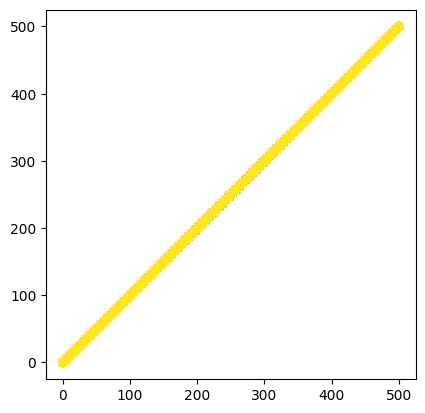

[0.30801048 0.57838636 0.61786915 0.64051294 0.04388823 0.20771386
 0.44874521 0.42541961 0.22901002 0.60016082 0.96068364 0.55205959
 0.89470014 0.82657708 0.27298964 0.06207532 0.4837778  0.58564254
 0.24812571 0.78783441 0.68493151 0.29678063 0.27596078 0.55565661
 0.47591635 0.23092691 0.02346464 0.47169646 0.26562581 0.50187172
 0.37321879 0.84204424 0.08465515 0.09622529 0.26712557 0.52690867
 0.32042177 0.42742744 0.16493021 0.98935711 0.44735623 0.56722923
 0.61696391 0.17883726 0.20771167 0.51792521 0.31737802 0.16836536
 0.41993126 0.90723384 0.17929174 0.53968993 0.33336776 0.26013748
 0.18129318 0.23621276 0.455321   0.97398657 0.43124798 0.61947683
 0.19332986 0.39322077 0.94855071 0.88402527 0.88211634 0.07242328
 0.80887957 0.49711199 0.63182008 0.1026424  0.1391842  0.05368064
 0.16913318 0.06691508 0.94496445 0.01218005 0.65086034 0.4788341
 0.22702372 0.10309731 0.10681536 0.11174257 0.52270256 0.21799728
 0.51751138 0.77590749 0.78843299 0.51027229 0.59780124 0.45349

<Figure size 640x480 with 0 Axes>

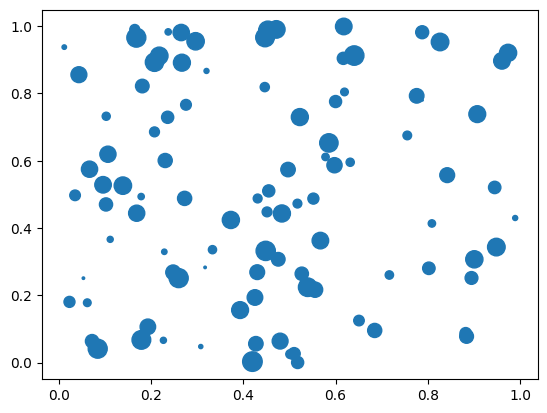

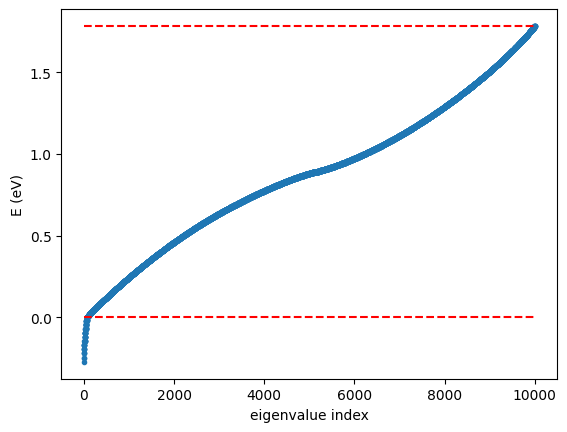

In [119]:
#show_hamiltonian(H)
plot_potential_on_grid_heat(Layout, site_size, site_elements, V_max, r_0)
#plot_potential_on_grid(Layout, site_size, 100, V_max, r_0)
#show_hamiltonian(H)
plot_eigenvalues_hamiltonian_whole(diagH, t)

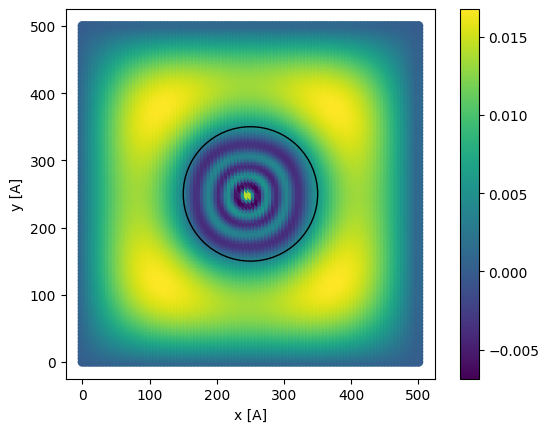

In [117]:
plot_psi_on_grid(psi, 72, Layout, site_size, site_elements, r_0)
#plot_psi_on_grid(psi, i, Layout_base, site_size, site_elements, r_0)

# Calculate wave function in the potential

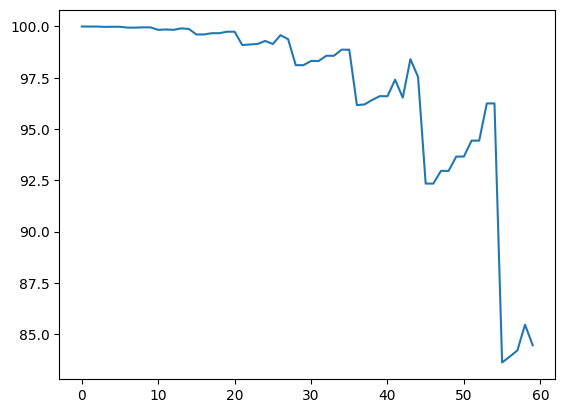

In [107]:


psi_in_dot(psi, 3, Layout, site_elements, r_0)
p_psi_on_n(psi, 60, Layout, site_elements, r_0)

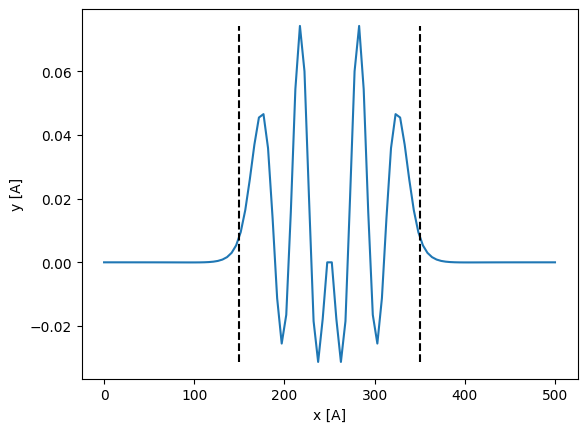

In [108]:

psi_in_dot_1D(psi, 60, Layout, site_size, site_elements, r_0)

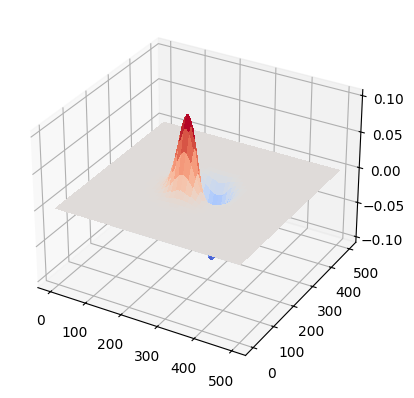

In [275]:
x = np.linspace(0,site_size,site_elements)
xx, yy = np.meshgrid(x, x)

#R = ((a*xx)**2 + (a*yy)**2)

#f = lambda R, V_max, r_0: V_n(R, V_max, r_0)
#Potencial = np.array(list(map(f, R, np.full(len(R), V_max), np.full(len(R), r_0))))

# show all Potencial
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(xx, yy, psi_test, cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
plt.show()

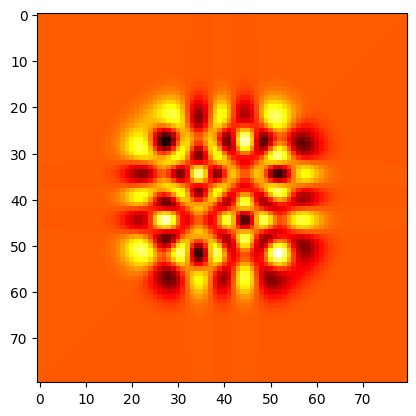

In [280]:
plt.imshow(psi_test, cmap='hot', interpolation='nearest')
plt.show()

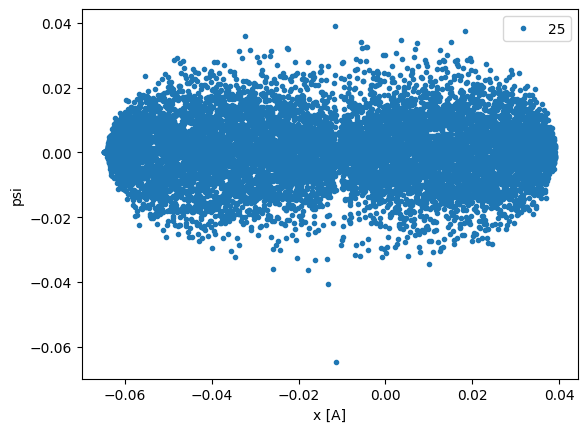

In [112]:
plot_psi_n(psi, 25)

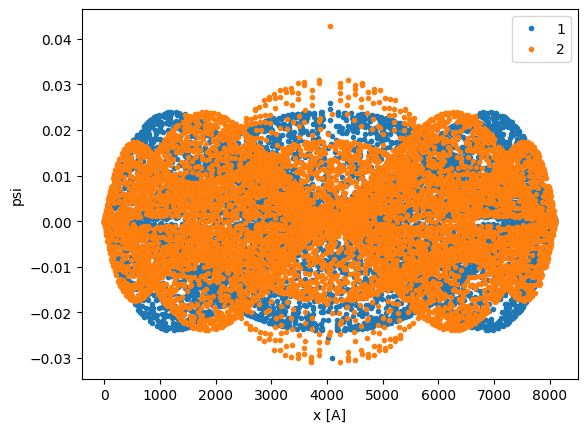

In [171]:
plot_psi_range(psi,1,3)

In [10]:
site_size = 500
site_elements = 20
PBC = True
V_max = 0.1 
r_0 = 150
m_eff = 0.067
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar = scipy.constants.hbar
_1eV = scipy.constants.physical_constants["electron volt"][0]
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)

omega = omega_calc(V_max, r_0, _1eV)
#print(omega)
#arr_an_en(3, omega, V_max, hbar, _1eV)
analitical_energies(0, 0, omega, V_max, hbar, _1eV)

TypeError: omega_calc() missing 2 required positional arguments: 'm_0' and '_1eV'

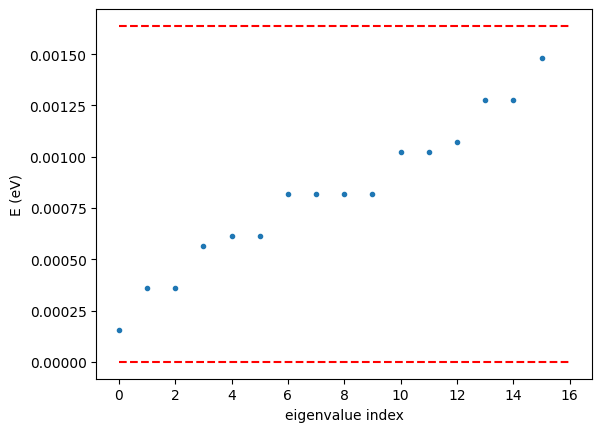

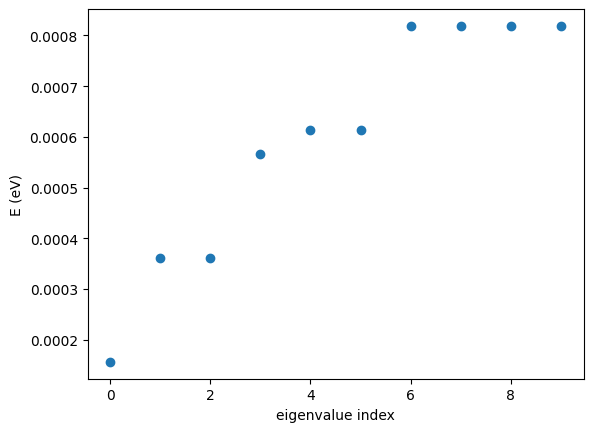

In [442]:
# definitions of fundamental constant used in calculations

site_size = 500
site_elements = 4
PBC = False
V_max = 0 
r_0 = 150
m_eff = 0.067
m_0 = scipy.constants.physical_constants["atomic unit of mass"][0]
hbar = scipy.constants.hbar
_1eV = scipy.constants.physical_constants["electron volt"][0]
a = a_calc(site_size, site_elements)
t = t_calc(a, m_eff, m_0, hbar, _1eV)


Layout = initialize_layout(site_elements, a)
H = initialize_hamiltonian(Layout, t, PBC, V_max, r_0)
diagH = diagonalize_hamiltonian(H)

#plot_potential_on_grid(Layout, site_size, site_elements, V_max, r_0)
#plot_potential_on_grid(Layout, site_size, 100, V_max, r_0)
#show_hamiltonian(H)
plot_eigenvalues_hamiltonian_whole(diagH, t)
plot_eigenvalues_hamiltonian(diagH[:10])

In [100]:
V_max = 0.3 
r_0 = 200
elements_list = [27, 100]

omega = omega_calc(V_max, r_0, m_eff, m_0,  _1eV)
print(omega)
ham_list = [analitical_energies(10, omega, V_max, hbar, _1eV)]
idx = 0 
for i in elements_list:
    ham_list.append(eigenvalues_hamiltonian(
            site_size=site_size,
            site_elements=i,
            PBC=PBC,
            V_max=V_max, 
            r_0=r_0,
            m_eff=m_eff,
            m_0=m_0,
            hbar=hbar,
            _1eV=_1eV
    ))
    idx+=1
# ham_list = ham_list[0:]

6275075091610.213


In [110]:
ham_list[0] = analitical_energies(10, omega, V_max, hbar, _1eV)

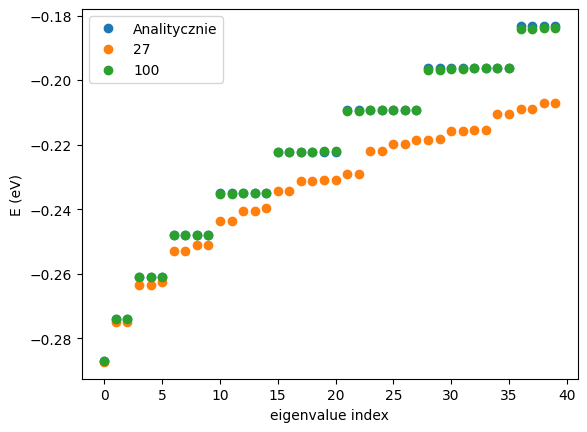

In [111]:
plot_multiple_eigenvalues_hamiltonian(ham_list,["Analitycznie", "27","100","60"], 40)

In [113]:
ham_list[2][1] - ham_list[2][0]

0.013013244981050665

In [112]:
(ham_list[2][1] - ham_list[2][0]) / (ham_list[0][1] - ham_list[0][0])

1.0028847753827195

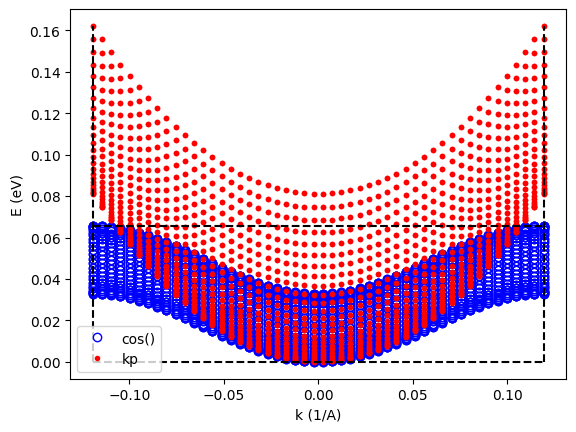

In [330]:
dispersion_2D(
    site_elements=50,
    t=t,
    a=a,
    hbar=hbar,
    m_eff=m_eff, 
    m_0=m_0,
    _1eV=_1eV,
    E0=0,
    dEs=0)

# Below is something that shouldn't be here - move it somewhere or delete

### Solving this Hamiltonian

Lets show how the difference betweet theoretical 8*t and numerical value are changing with the number of elements as the % of theoretical 8*t
- move to long

In [277]:
n10 = eigenvalues_hamiltonian(site_size=500, site_elements=10, PBC=False, V_max=0, r_0=0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
n20 = eigenvalues_hamiltonian(site_size=500, site_elements=20, PBC=False, V_max=0, r_0=0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
n30 = eigenvalues_hamiltonian(site_size=500, site_elements=30, PBC=False, V_max=0, r_0=0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
n40 = eigenvalues_hamiltonian(site_size=500, site_elements=40, PBC=False, V_max=0, r_0=0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)


In [ ]:
n50 = eigenvalues_hamiltonian(site_size=500, site_elements=50, PBC=False, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)


In [ ]:
#n150 = eigenvaluesHamiltonian(site_size=500, site_elements=150, PBC=False, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)[0]
#print(n10[0], n20[0], n30[0], n40[0], n50[0])
for i in range(3,10,1):
    a = a_calc(site_size=500, site_elements=i)
    t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    H = eigenvalues_hamiltonian(site_size=500, site_elements=i, PBC=False, V_max=0, r_0=0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    #plotEigenvaluesHamiltonian(H, t)
    print(H[0], H[i*i-1], (H[i*i-1] - H[0]), 8 * t, 8*t-(H[i*i-1] - H[0]))


0.00010659514513406909 0.0006212820352656653 0.0005146868901315962 0.0007278771803997345 0.00021319029026813823
0.00015638869309345834 0.0014813349628059439 0.0013249462697124854 0.0016377236558994027 0.0003127773861869173
0.00019503410267715258 0.002716474618921789 0.0025214405162446362 0.002911508721598938 0.00039006820535430163
0.00022525781625931513 0.004323974561239026 0.004098716744979711 0.00454923237749834 0.0004505156325186289
0.00024932858060877384 0.00630156604298884 0.006052237462380066 0.006550894623597611 0.000498657161217545
0.00026886523648036065 0.00864763022341639 0.008378764986936028 0.008916495459896747 0.0005377304729607194
0.00028499875934419257 0.011361036127051562 0.011076037367707368 0.011646034886395751 0.0005699975186883831


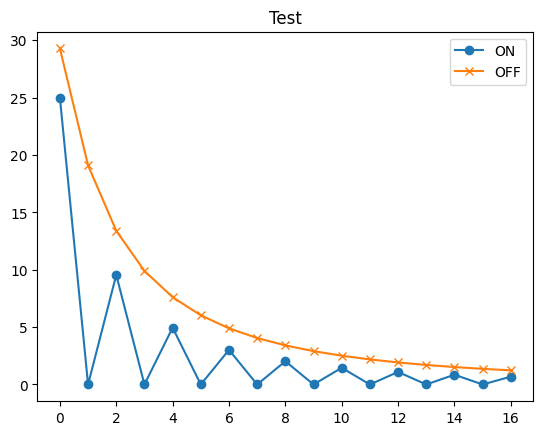

<Figure size 640x480 with 0 Axes>

In [429]:
# zbieżność do 0 w zależności od rozmiaru
def convergence_test(
        start_test_size,
        stop_test_size,
        site_size,
        V_max, 
        r_0,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    ON_PBC = np.zeros(stop_test_size-start_test_size)
    OFF_PBC = np.zeros(stop_test_size-start_test_size)


    for i in range(start_test_size,stop_test_size):
        a = a_calc(site_size=site_size, site_elements=i)
        t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)

        PBC = True
        ON = eigenvalues_hamiltonian(site_size=site_size, site_elements=i, PBC=PBC, V_max=V_max, r_0=r_0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        ON_PBC[i-start_test_size] = (8 * t - (ON[len(ON)-1] - ON[0])) / (8 * t) * 100

        PBC = False
        OFF = eigenvalues_hamiltonian(site_size=site_size, site_elements=i, PBC=PBC, V_max=V_max, r_0=r_0, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        OFF_PBC[i-start_test_size] = (8 * t - (OFF[len(OFF)-1] - OFF[0])) / (8 * t) * 100

    plt.plot(ON_PBC, "-o", label="ON")
    plt.plot(OFF_PBC, "-x", label="OFF")
    plt.title("Test")
    plt.legend()
    plt.show()
    plt.clf()
    
convergence_test(
        start_test_size=3,
        stop_test_size=20,
        site_size=500,
        V_max=0, 
        r_0=0, 
        m_eff=m_eff,
        m_0=m_0,
        hbar=hbar,
        _1eV=_1eV
)

In [ ]:
# zbieżność do 0 w zależności od rozmiaru
def convergence_test(
        start_test_size,
        stop_test_size,
        site_size,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    ON_PBC_first = np.zeros(stop_test_size-start_test_size)
    OFF_PBC_first = np.zeros(stop_test_size-start_test_size)
    ON_PBC_last = np.zeros(stop_test_size-start_test_size)
    OFF_PBC_last = np.zeros(stop_test_size-start_test_size)

    for i in range(start_test_size,stop_test_size):
        a = a_calc(site_size=site_size, site_elements=i)
        t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)

        PBC = True
        ON = eigenvaluesHamiltonian(site_size=site_size, site_elements=i, PBC=PBC, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        ON_PBC_first[i-start_test_size] = ON[0]
        ON_PBC_last[i-start_test_size] = t - ON[len(ON)-1]

        PBC = False
        OFF = eigenvaluesHamiltonian(site_size=site_size, site_elements=i, PBC=PBC, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        OFF_PBC_first[i-start_test_size] = OFF[0]
        OFF_PBC_last[i-start_test_size] = t - OFF[len(OFF)-1]

    plt.plot(ON_PBC_first, "-o", label="ON")
    plt.plot(OFF_PBC_first, "-x", label="OFF")
    plt.title("First")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.plot(ON_PBC_last, "-o", label="ON")
    plt.plot(OFF_PBC_last, "-x", label="OFF")
    plt.title("Last")
    plt.legend()
    plt.show()
    plt.clf()

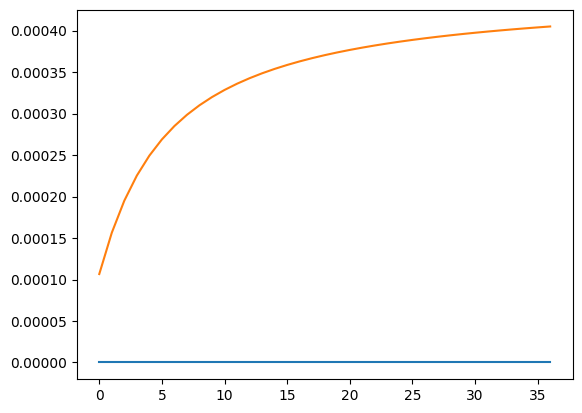

In [ ]:
# zbieżność do 0 w zależności od rozmiaru
N = 40
smallest = 3
ON_PBC_first = np.zeros(N-smallest)
OFF_PBC_first = np.zeros(N-smallest)

for i in range(smallest,N):
    a = a_calc(site_size=500, site_elements=i)
    t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    ON_PBC_first[i-smallest] = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(i, a), t, True))[0]
    OFF_PBC_first[i-smallest] = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(i, a), t, False))[0]
plt.plot(ON_PBC_first)
plt.plot(OFF_PBC_first)
plt.show()

In [ ]:
# zbieżność do 0 w zależności od rozmiaru
def convergence_test(
        start_test_size,
        stop_test_size,
        site_size,
        m_eff,
        m_0,
        hbar,
        _1eV
):
    ON_PBC_first = np.zeros(stop_test_size-start_test_size)
    OFF_PBC_first = np.zeros(stop_test_size-start_test_size)
    ON_PBC_last = np.zeros(stop_test_size-start_test_size)
    OFF_PBC_last = np.zeros(stop_test_size-start_test_size)

    for i in range(start_test_size,stop_test_size):
        a = a_calc(site_size=site_size, site_elements=i)
        t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)

        PBC = True
        ON = eigenvaluesHamiltonian(site_size=site_size, site_elements=i, PBC=PBC, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        ON_PBC_first[i-start_test_size] = ON[0]
        ON_PBC_last[i-start_test_size] = t - ON[len(ON)-1]

        PBC = False
        OFF = eigenvaluesHamiltonian(site_size=site_size, site_elements=i, PBC=PBC, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
        OFF_PBC_first[i-start_test_size] = OFF[0]
        OFF_PBC_last[i-start_test_size] = t - OFF[len(OFF)-1]

    plt.plot(ON_PBC_first, "-o", label="ON")
    plt.plot(OFF_PBC_first, "-x", label="OFF")
    plt.title("First")
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.plot(ON_PBC_last, "-o", label="ON")
    plt.plot(OFF_PBC_last, "-x", label="OFF")
    plt.title("Last")
    plt.legend()
    plt.show()
    plt.clf()

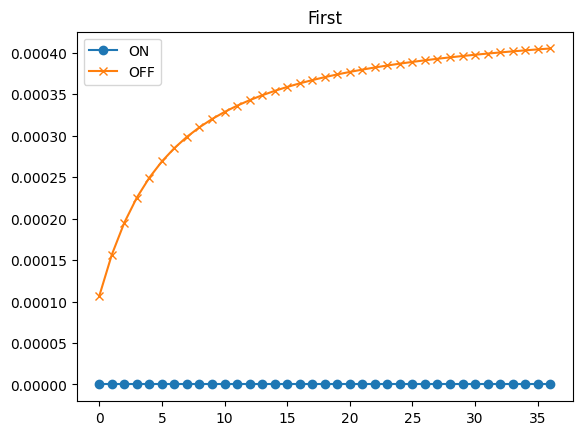

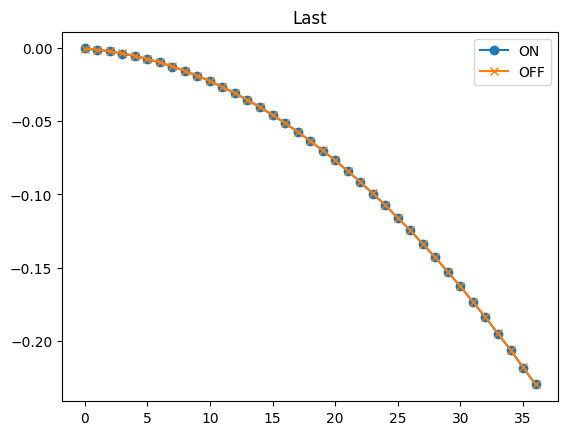

<Figure size 640x480 with 0 Axes>

In [ ]:
# zbieżność do 0 w zależności od rozmiaru
N = 40
smallest = 3
ON_PBC_first = np.zeros(N-smallest)
OFF_PBC_first = np.zeros(N-smallest)
ON_PBC_last = np.zeros(N-smallest)
OFF_PBC_last = np.zeros(N-smallest)
for i in range(smallest,N):
    a = a_calc(site_size=500, site_elements=i)
    t = t_calc(a=a, m_eff=m_eff, m_0=m_0, hbar=hbar, _1eV=_1eV)
    ON = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(i, a), t, True))
    ON_PBC_first[i-smallest] = ON[0]
    ON_PBC_last[i-smallest] = t - ON[len(ON)-1]
    OFF = diagonalize_hamiltonian(initialize_hamiltonian(initialize_layout(i, a), t, False))
    OFF_PBC_first[i-smallest] = OFF[0]
    OFF_PBC_last[i-smallest] = t - OFF[len(OFF)-1]

plt.plot(ON_PBC_first, "-o", label="ON")
plt.plot(OFF_PBC_first, "-x", label="OFF")
plt.title("First")
plt.legend()
plt.show()
plt.clf()

plt.plot(ON_PBC_last, "-o", label="ON")
plt.plot(OFF_PBC_last, "-x", label="OFF")
plt.title("Last")
plt.legend()
plt.show()
plt.clf()

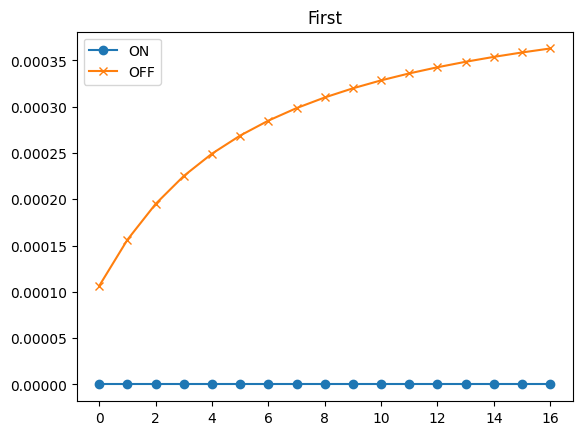

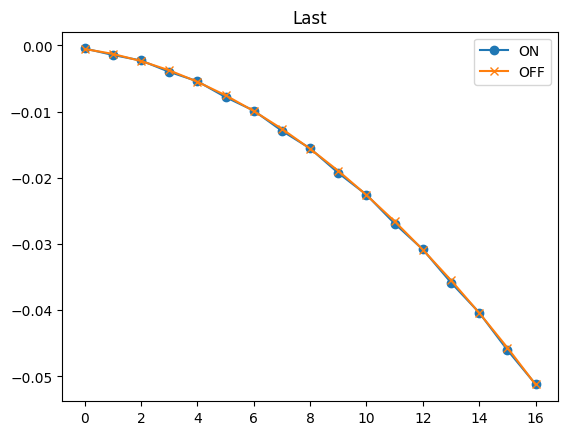

<Figure size 640x480 with 0 Axes>

In [ ]:
convergence_test(
        start_test_size=3,
        stop_test_size=20,
        site_size=500,
        m_eff=m_eff,
        m_0=m_0,
        hbar=hbar,
        _1eV=_1eV
)

### V(x,y)

In [ ]:
r_0 = 20 #[nm]
V_max = 0.3 #[eV]
a = 1
N_help = 30

In [433]:
def V_n_direct(dist_sqr, V_max, r_0):
    dist_sqr = abs(dist_sqr)
    if np.sqrt(dist_sqr) >= r_0:
        #print(dist_sqr, 0)
        return 0
    else:
        #print(dist_sqr, V_max/(r_0*r_0) * dist_sqr - V_max)
        return V_max/(r_0*r_0) * dist_sqr - V_max

def V_n(dist_sqr, V_max, r_0):
    dist_sqr = dist_sqr
    a_help = np.zeros_like(dist_sqr)
    for i in range(len(dist_sqr)):
        a_help[i] = V_n_direct(dist_sqr[i], V_max, r_0)
    return a_help

def show_potential_grid(site_elements, a,  V_max, r_0):
    Layout = initialize_layout(site_elements, a)
    x = np.linspace(-site_elements*a,site_elements*a,site_elements)
    y = np.linspace(-site_elements*a,site_elements*a,site_elements) 
    xx, yy = np.meshgrid(x, y)

    R = ((a*xx)**2 + (a*yy)**2)

    f = lambda R, V_max, r_0: V_n(R, V_max, r_0)
    Potencial = np.array(list(map(f, R, np.full(len(R), V_max), np.full(len(R), r_0))))

    #  show middle Potencial
    '''plt.plot(Potencial[math.floor(len(Potencial)/2)])
    plt.ylabel("V(x,y)")
    plt.xlabel("x (A)")
    plt.show()
    plt.clf()
    '''
    # show all Potencial
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xx, yy, Potencial, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)
    plt.show()
    plt.clf()

    #for elem in Layout["realLocation"]:
    #    plt.scatter(elem[1][0], elem[1][1], c='blue', linewidths=1)
    X = np.zeros(len(Layout["realLocation"]))
    Y = np.zeros(len(Layout["realLocation"]))
    for i in range(len(Layout["realLocation"])):
        elem = Layout["realLocation"][i]
        X[i] = elem[1][0]
        Y[i] = elem[1][1]
    plt.scatter(X, Y, c='blue', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.imshow(Potencial, cmap=cm.plasma)
    plt.colorbar()
    plt.show()

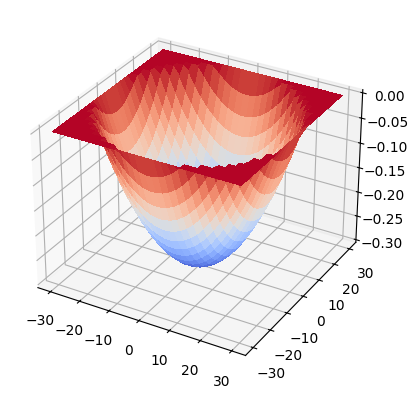

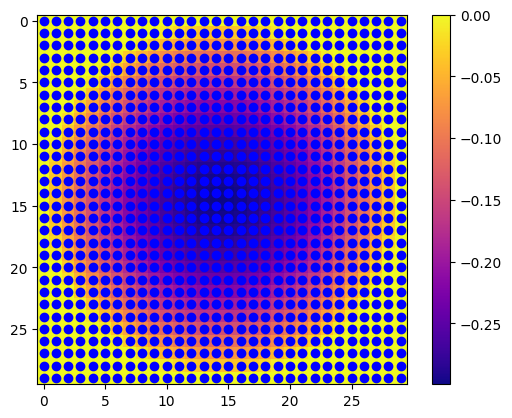

In [434]:
show_potential_grid(30,1,0.3,30)

### Hamiltonian with the potencial

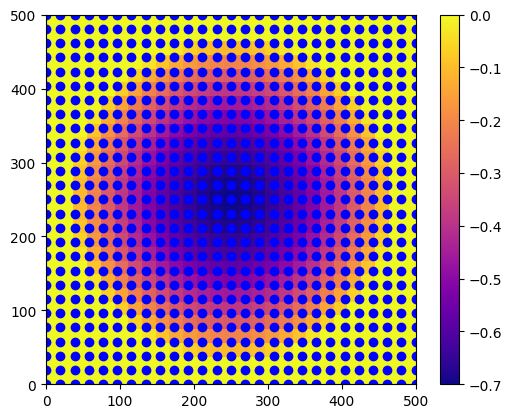

In [ ]:
site_size, site_elements = 500, 27
V_max, r_0 = 0.7, 230
Layout = initialize_layout(site_elements, a_calc(site_size, site_elements))
#Layout["realLocation"]
plot_potential_on_grid(Layout, site_size, site_elements, V_max, r_0)

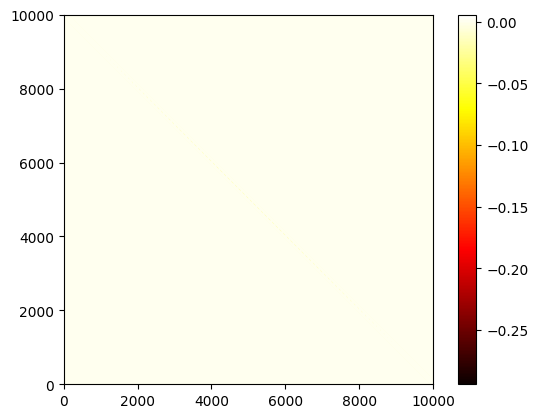

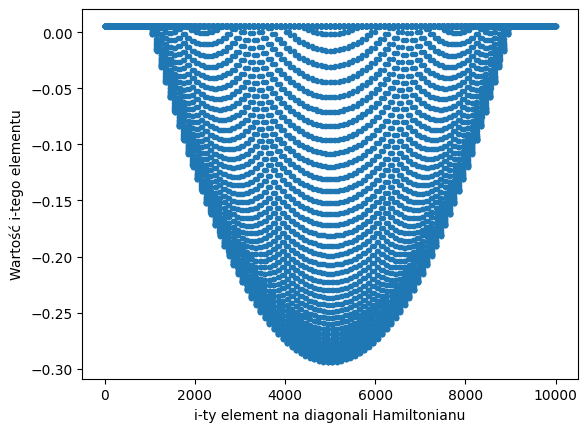

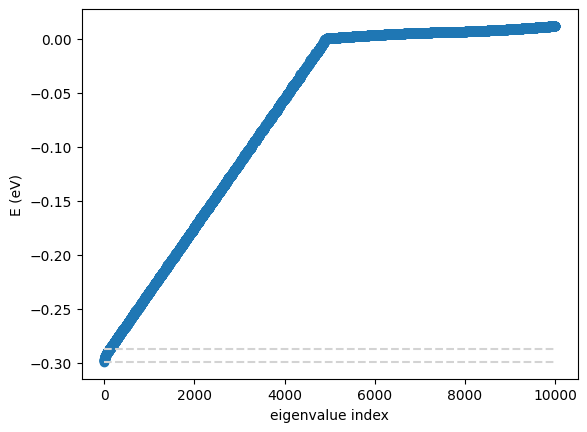

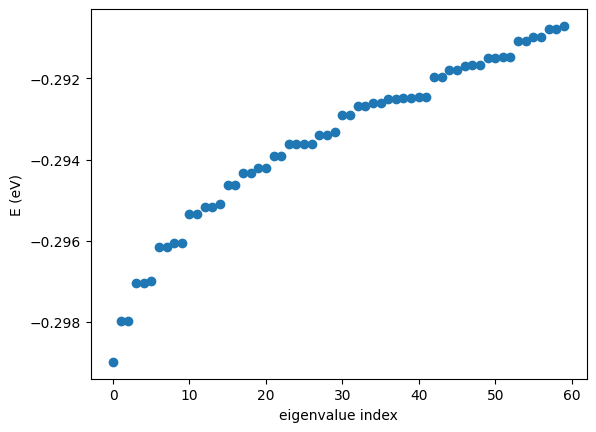

In [ ]:
r_0 = 40
V_max = 0.3
n = 100
# show hamiltonian
Layout = initialize_layout(n, a)
Hamiltonian = initialize_hamiltonian(Layout, t, True)

ran = math.floor(math.sqrt(Hamiltonian.size))
plt.imshow(Hamiltonian, cmap='hot', extent=[0, ran, 0, ran])
plt.colorbar() 
plt.show()

aaa = np.zeros(ran)
for i in range(ran):
    aaa[i] = Hamiltonian[i][i]
plt.clf()
plt.plot(aaa, ".")
plt.xlabel("i-ty element na diagonali Hamiltonianu")
plt.ylabel("Wartość i-tego elementu")
plt.show()

diagonalizated_hamiltonain = diagonalize_hamiltonian(Hamiltonian)

plt.plot(diagonalizated_hamiltonain, 'o')
bottom = np.amin(diagonalizated_hamiltonain)
plt.hlines(8*t+bottom, 0, len(diagonalizated_hamiltonain), colors="lightgray", linestyles="--")
plt.hlines(bottom, 0, len(diagonalizated_hamiltonain), colors="lightgray", linestyles="--")
plt.xlabel("eigenvalue index")
plt.ylabel("E (eV)")
plt.show()

plt.plot(diagonalizated_hamiltonain[:60], 'o')
plt.xlabel("eigenvalue index")
plt.ylabel("E (eV)")
plt.show()


In [412]:
def omega_calc(V, r):
    return np.sqrt((2*V*_1eV)/(r*10e-10)**2)

omega = omega_calc(V_max, r_0)
calculation = diagonalizated_hamiltonain[1]-diagonalizated_hamiltonain[0]
print(omega, calculation, omega - calculation, abs(omega - calculation)/omega*100, a, _1eV, V_max, r_0)

0.0011933804959022916 0.0009956238076523904 0.00019775668824990118 16.57113459864125 26.31578947368421 1.602176634e-19 0.1 150
